# Ensemble: pr (over sea-ice and ocean)

## Imports & defaults

In [1]:
import libs.analysis
import libs.ensemble
import libs.local
import libs.plot
import libs.vars
import matplotlib
import warnings
import xarray

matplotlib.rcParams.update({ 'font.size': 18 })
warnings.filterwarnings('ignore')
xarray.set_options(keep_attrs=True);

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'Amon'
experiment = 'ssp585'
variable_id = 'pr'

spatial_text = 'precipitation (solid) net pr (dashed) over sea-ice and ocean'
spatial_units = 'mm day⁻¹' # base units kg m-2 s-1

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
time_series_text = conf['text']
time_series_weighted_method = 'sum'

In [3]:
ensemble, weight = libs.ensemble.get_and_preprocess(
    component, 
    experiment, 
    variable_id,
    preprocess=conf['preprocess']
)

In [4]:
conf_evspsbl = [v for v in libs.vars.variables() if v['variable_id'] == 'evspsbl'][0]
ensemble_evspsbl, weight_evspsbl = libs.ensemble.get_and_preprocess(
    'Amon', 
    experiment, 
    'evspsbl',
    preprocess=conf_evspsbl['preprocess']
)

data_vars = {}
for item in ensemble:
    item_mask = [item_mask for item_mask in ensemble_evspsbl if item_mask['label'] == item['label']]
    if len(item_mask) == 0:
        continue
        
    item_mask = item_mask[0]['data']
    processed_data = item['data']
    processed_data.attrs['color'] = item['color']
    processed_data = processed_data.drop_vars(['height', 'type'], errors='ignore')
    item_mask = item_mask.drop_vars(['height', 'type'], errors='ignore')

    item_weighted = (processed_data - item_mask).weighted(weight)
    item_reduced = getattr(
        item_weighted, 
        time_series_weighted_method
    )(dim=item_weighted.weights.dims, skipna=True)
    
    data_vars[item['label']] = item_reduced

ds_prnet = xarray.Dataset(data_vars=data_vars)
ds_prnet = libs.ensemble.calc_variable_mean(ds_prnet)

## Time series

### Mean

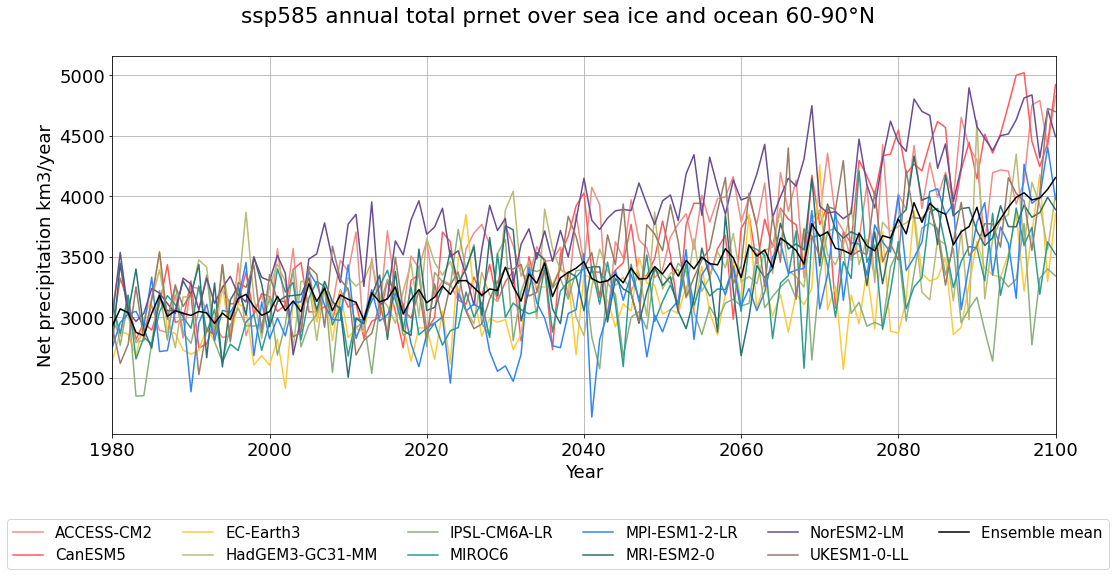

In [5]:
vars_series = [
    ds_prnet
]
plot_arr = []
for item in vars_series:
    # Convert from day-1 to month-1, then tally total for yearly total net
    item_processed = (item * 30).groupby('time.year').sum('time')
    
    # Convert from kg to m3, assuming density of 1000
    item_processed /= 1000
    
    # Convert from m3 to km3
    item_processed /= 1000000000
    
    # Re-calc ensemble mean
    item_processed = libs.ensemble.calc_variable_mean(item_processed)
    plot_arr.append(item_processed)

libs.plot.time_series_from_vars(
    plot_arr,
    title=f'{experiment} annual total prnet over sea ice and ocean 60-90°N',
    xattr='year',
    ylabel='Net precipitation km3/year'
);

In [6]:
vars_series = [
    { 'ds': ds_prnet, 'key': 'prnet' }
]

for obj in vars_series:
    print('-----', obj['key'], '-----')
    ds = obj['ds']
    
        # Convert from day-1 to month-1, then tally total for yearly total net
    ds = (ds * 30).groupby('time.year').sum('time')
    
    # Convert from kg to m3, assuming density of 1000
    ds /= 1000
    
    # Convert from m3 to km3
    ds /= 1000000000
    
    ds = libs.ensemble.calc_variable_mean(ds)
    
    libs.analysis.calc_diffs(ds, unit='km3', relative=False)    

----- prnet -----
ACCESS-CM2
-> 1980-2010: 3091.69km3
-> 2080-2100: 4243.55km3
-> delta: 1151.86km3
CanESM5
-> 1980-2010: 3096.88km3
-> 2080-2100: 4461.85km3
-> delta: 1364.97km3
EC-Earth3
-> 1980-2010: 2915.13km3
-> 2080-2100: 3417.59km3
-> delta: 502.45km3
HadGEM3-GC31-MM
-> 1980-2010: 3156.49km3
-> 2080-2100: 3688.35km3
-> delta: 531.85km3
IPSL-CM6A-LR
-> 1980-2010: 2944.19km3
-> 2080-2100: 3300.62km3
-> delta: 356.43km3
MIROC6
-> 1980-2010: 2994.81km3
-> 2080-2100: 3520.39km3
-> delta: 525.58km3
MPI-ESM1-2-LR
-> 1980-2010: 3014.04km3
-> 2080-2100: 3765.18km3
-> delta: 751.14km3
MRI-ESM2-0
-> 1980-2010: 3104.47km3
-> 2080-2100: 3872.57km3
-> delta: 768.10km3
NorESM2-LM
-> 1980-2010: 3264.39km3
-> 2080-2100: 4523.91km3
-> delta: 1259.52km3
UKESM1-0-LL
-> 1980-2010: 3101.36km3
-> 2080-2100: 3864.12km3
-> delta: 762.77km3
Ensemble mean
-> 1980-2010: 3068.34km3
-> 2080-2100: 3865.81km3
-> delta: 797.47km3

Range 356.43382049992397 - 1364.9703473038562
Median 860.7020839018901
Mean 797.4